In [13]:
import json
from pathlib import Path

import fire
import wandb

from spd.configs import Config
from spd.experiments.tms.configs import TMSTaskConfig
from spd.experiments.tms.models import TMSModel, TMSTargetRunInfo
from spd.log import logger
from spd.run_spd import optimize
from spd.utils.data_utils import DatasetGeneratedDataLoader, SparseFeatureDataset
from spd.utils.distributed_utils import get_device
from spd.utils.general_utils import (
    load_config,
    save_pre_run_info,
    set_seed,
)
from spd.utils.run_utils import get_output_dir
from spd.utils.wandb_utils import init_wandb

config = load_config("../experiments/tms/tms_5-2_config.yaml", config_model=Config)
device = get_device()

assert config.pretrained_model_path, "pretrained_model_path must be set"
target_run_info = TMSTargetRunInfo.from_path(config.pretrained_model_path)
target_model = TMSModel.from_run_info(target_run_info)
target_model = target_model.to(device)
target_model.eval()

Downloaded checkpoint from /workspace/spd-backchaining/wandb/0hsp07o4/files/tms.pth


TMSModel(
  (linear1): Linear(in_features=5, out_features=2, bias=False)
  (linear2): Linear(in_features=2, out_features=5, bias=True)
)

In [14]:
print(target_model.linear1.weight)

Parameter containing:
tensor([[ 0.8253,  0.9843, -0.4904, -0.1874, -1.1319],
        [ 0.7684, -0.5487,  1.0253, -1.1113, -0.1662]], device='cuda:0',
       requires_grad=True)


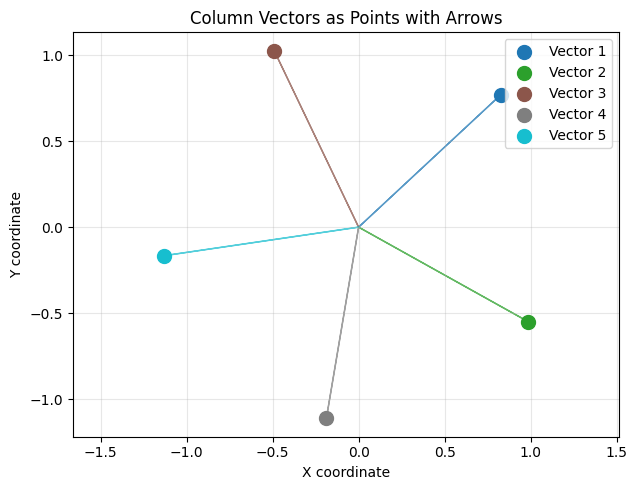

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tensor(tensor):
    # Method 1: Plot vectors from origin using quiver
    plt.figure(figsize=(12, 5))

    # Subplot 2: Alternative visualization - scatter plot with arrows
    plt.subplot(1, 2, 2)
    colors = plt.cm.tab10(np.linspace(0, 1, tensor.shape[1]))

    for i in range(tensor.shape[1]):
        vector = tensor[:, i]
        # Plot the point
        plt.scatter(vector[0], vector[1], color=colors[i], s=100, 
                    label=f'Vector {i+1}', zorder=5)
        # Draw arrow from origin to point
        plt.arrow(0, 0, vector[0], vector[1], 
                head_width=0, head_length=0, 
                fc=colors[i], ec=colors[i], alpha=0.7)

    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Column Vectors as Points with Arrows')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Create a sample tensor of shape [2, 5]
tensor = target_model.linear1.weight.detach().cpu().numpy()
plot_tensor(tensor)

In [16]:
from spd.models.component_model import ComponentModel
import torch

state_dict = torch.load("/root/spd_cache/runs/spd-bfx7fnul/model_10000.pth", map_location="cpu")

target_model.requires_grad_(False)
component_model = ComponentModel(
    target_model=target_model,
    target_module_patterns=config.target_module_patterns,
    C=config.C,
    gate_type=config.gate_type,
    gate_hidden_dims=config.gate_hidden_dims,
    pretrained_model_output_attr=config.pretrained_model_output_attr,
    identity_module_patterns=config.identity_module_patterns,
)

component_model.load_state_dict(state_dict)
component_model.eval()

ComponentModel(
  (patched_model): TMSModel(
    (linear1): ComponentsOrModule(
      (original): Linear(in_features=5, out_features=2, bias=False)
      (components): LinearComponents()
    )
    (linear2): ComponentsOrModule(
      (original): Linear(in_features=2, out_features=5, bias=True)
      (components): LinearComponents()
    )
  )
  (_gates): ModuleDict(
    (linear1): GateMLPs(
      (layers): Sequential(
        (0): ParallelLinear()
        (1): GELU(approximate='none')
        (2): ParallelLinear()
      )
    )
    (linear2): GateMLPs(
      (layers): Sequential(
        (0): ParallelLinear()
        (1): GELU(approximate='none')
        (2): ParallelLinear()
      )
    )
  )
)

In [ ]:
U = component_model.patched_model.linear1.components.U
V = component_model.patched_model.linear1.components.V
weight_components = torch.einsum('cu,vc->cuv', U, V)
print(weight_components.shape)
for i in range(weight_components.shape[0]):
    plot_tensor(weight_components[i].detach().cpu().numpy())

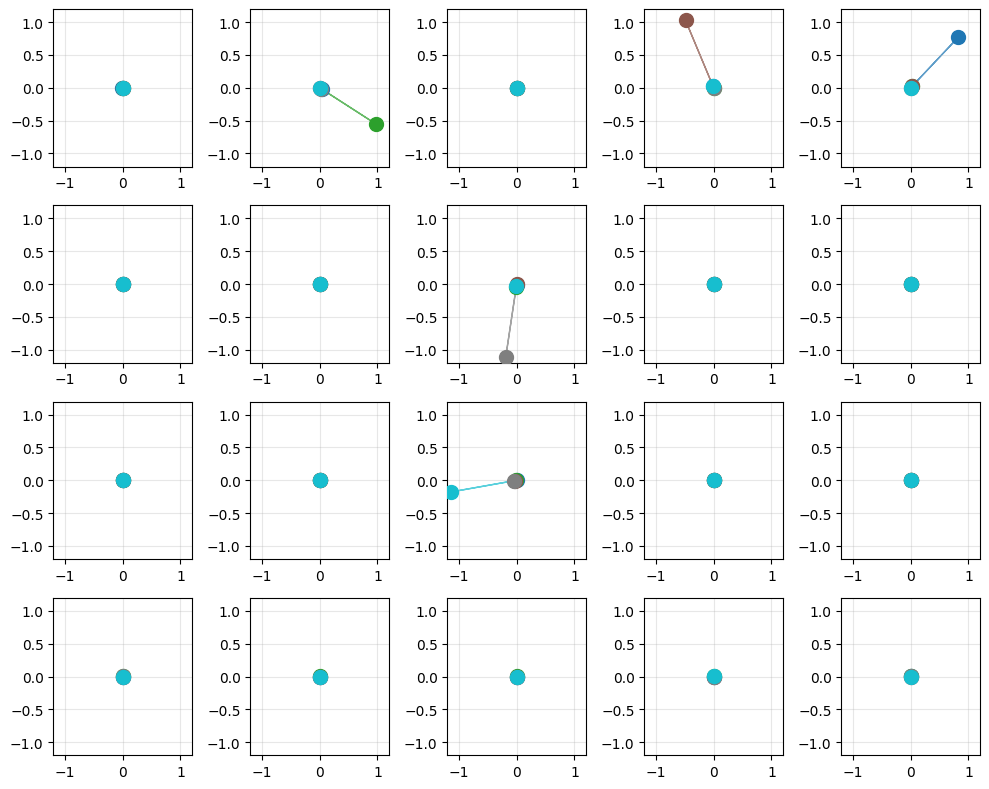

In [ ]:
U = component_model.patched_model.linear1.components.U
V = component_model.patched_model.linear1.components.V
weight_components = torch.einsum('cu,vc->cuv', U, V).detach().cpu().numpy()

plt.figure(figsize=(10, 8))

# Subplot 2: Alternative visualization - scatter plot with arrows
for i in range(weight_components.shape[0]):
    plt.subplot(4, 5, i+1)
    colors = plt.cm.tab10(np.linspace(0, 1, weight_components[i].shape[1]))

    for j in range(weight_components[i].shape[1]):
        vector = weight_components[i][:, j]
        # Plot the point
        plt.scatter(vector[0], vector[1], color=colors[j], s=100, 
                    label=f'Vector {i+1}', zorder=5)
        # Draw arrow from origin to point
        plt.arrow(0, 0, vector[0], vector[1], 
                head_width=0, head_length=0, 
                fc=colors[j], ec=colors[j], alpha=0.7)

    plt.grid(True, alpha=0.3)
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.tight_layout()
plt.show()


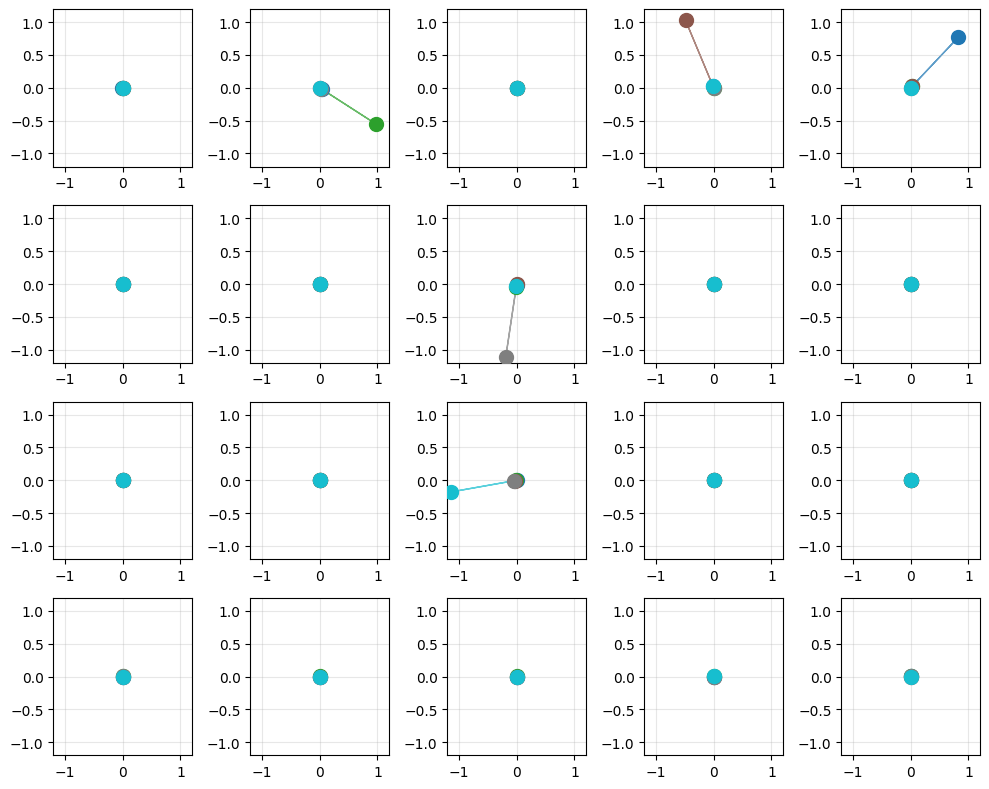

In [31]:
U = component_model.patched_model.linear2.components.U
V = component_model.patched_model.linear2.components.V
weight_components = torch.einsum('cu,vc->cuv', U, V).detach().cpu().numpy().transpose(0, 2, 1)

plt.figure(figsize=(10, 8))

# Subplot 2: Alternative visualization - scatter plot with arrows
for i in range(weight_components.shape[0]):
    plt.subplot(4, 5, i+1)
    colors = plt.cm.tab10(np.linspace(0, 1, weight_components[i].shape[1]))

    for j in range(weight_components[i].shape[1]):
        vector = weight_components[i][:, j]
        # Plot the point
        plt.scatter(vector[0], vector[1], color=colors[j], s=100, 
                    label=f'Vector {i+1}', zorder=5)
        # Draw arrow from origin to point
        plt.arrow(0, 0, vector[0], vector[1], 
                head_width=0, head_length=0, 
                fc=colors[j], ec=colors[j], alpha=0.7)

    plt.grid(True, alpha=0.3)
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.tight_layout()
plt.show()